In [2]:
import numpy as np
from scipy.stats import norm

from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters


def simulate_gaussian_annotations(B, N, K, rho, p):
    """
    B: number of trials
    N: number of samples per trial
    K: number of annotators
    rho: correlation between annotators
    p: marginal probability of a positive outcome    
    """
    # Create a KxK covariance matrix with off-diagonals equal to rho.
    cov = np.full((K, K), rho)
    np.fill_diagonal(cov, 1)
    # Generate B * N samples from the multivariate normal.
    z = np.random.multivariate_normal(np.zeros(K), cov, size=B * N)
    # Reshape to get an array of shape (B, N, K)
    z = z.reshape(B, N, K)
    # Compute the threshold corresponding to the desired marginal probability p.
    threshold = norm.ppf(1 - p)
    # Convert latent values to binary outcomes using the computed threshold.
    annotations = (z > threshold).astype(int)
    return annotations

# e.g.
B = 1_000
N = 100
K = 3
rho = 0.8
p = 0.5
data = simulate_gaussian_annotations(B, N, K, rho, p)
print(data.shape)  # (1000, 100, 3)


(1000, 100, 3)


In [3]:
table, _ = aggregate_raters(data[0])
fleiss_kappa(table)

0.6116071428571426

In [4]:
from tqdm import tqdm

# rhos = np.linspace(0, 1, 11)
rhos = [0, .01, .25, .5, .75, .99, 1.0]
ps = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

pbar = tqdm(total=len(rhos) * len(ps))
results = []
for rho in rhos:
    for p in ps:
        res = []
        data = simulate_gaussian_annotations(B, N, K, rho, p)
        # % of agreement for all trials
        frac_agree = (np.std(data, axis=2) == 0).mean(axis=1)
        for b in range(B):
            table, _ = aggregate_raters(data[b])
            kappa = fleiss_kappa(table)
            res.append({'rho': rho, 'p': p, 'kappa': kappa})
        # Add the fraction of agreement to the results:
        for i, r in enumerate(res):
            r['frac_agree'] = frac_agree[i]
        results.extend(res)
        pbar.update(1)
pbar.close()

 12%|█▏        | 6/49 [00:00<00:04,  9.59it/s]/home/fvalentini/miniconda3/envs/spanish-ir/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:266: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)
100%|██████████| 49/49 [00:05<00:00,  9.74it/s]


In [5]:
import pandas as pd

df = pd.DataFrame(results)

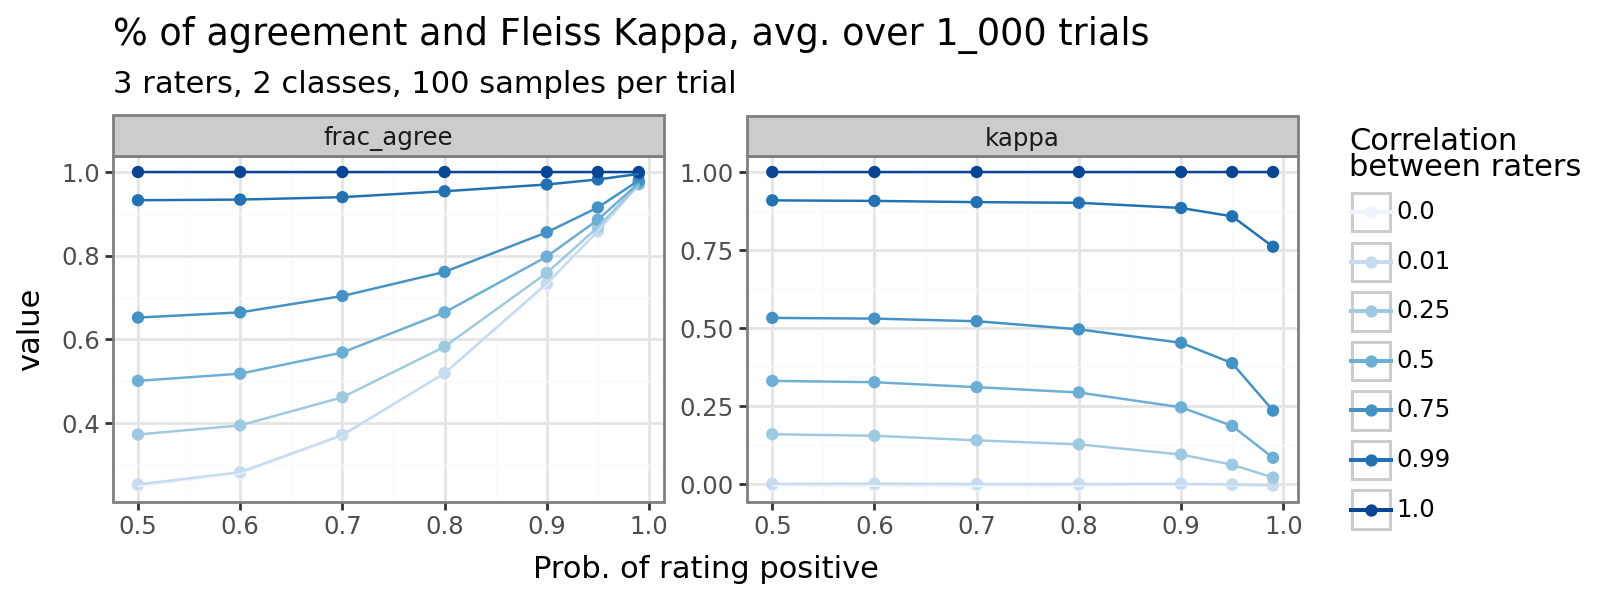

In [23]:
import plotnine as p9

df_avg = df.groupby(['rho', 'p']).mean().reset_index()
# melt for plot:
df_plot = pd.melt(
    df_avg, id_vars=['rho', 'p'], value_vars=['kappa', 'frac_agree'], var_name='metric', value_name='value'
)

p = (
    p9.ggplot(df_plot, p9.aes(x='p', y="value", color='factor(rho)', group='factor(rho)'))
    # p9.ggplot(df_plot, p9.aes(x='rho', y="value", color='factor(p)', group='factor(p)'))
    # p9.ggplot(df_plot, p9.aes(x='value', y="rho", color='factor(p)', group='factor(p)'))
    + p9.geom_point()
    + p9.geom_line()
    + p9.theme_bw()
    + p9.facet_wrap('~metric', scales='free_y')
    + p9.scale_color_brewer()
    + p9.labs(
        x='Prob. of rating positive',
        color='Correlation\nbetween raters',
        title=r'% of agreement and Fleiss Kappa, avg. over 1_000 trials',
        subtitle=r'3 raters, 2 classes, 100 samples per trial',
    )
    + p9.theme(figure_size=(8, 3))
)
p.show()

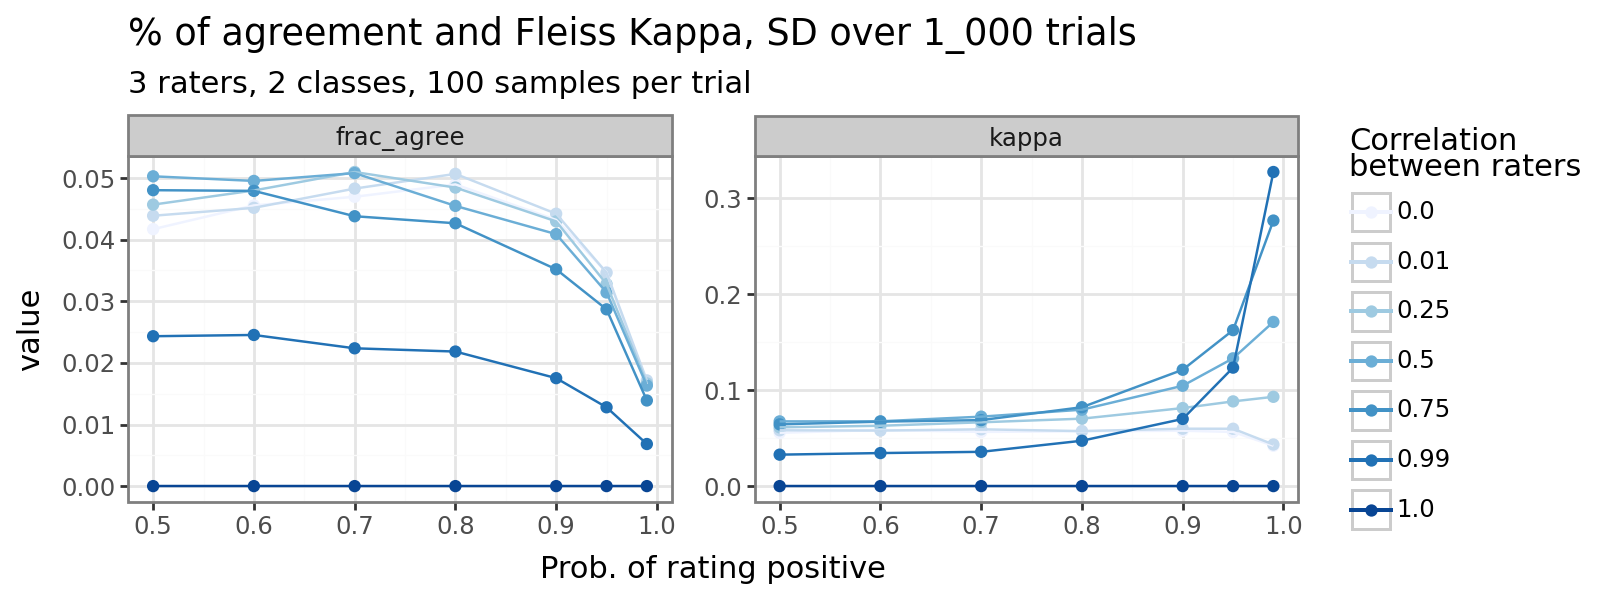

In [20]:
import plotnine as p9

df_avg = df.groupby(['rho', 'p']).std().reset_index()
# melt for plot:
df_plot = pd.melt(
    df_avg, id_vars=['rho', 'p'], value_vars=['kappa', 'frac_agree'], var_name='metric', value_name='value'
)

p = (
    p9.ggplot(df_plot, p9.aes(x='p', y="value", color='factor(rho)', group='factor(rho)'))
    # p9.ggplot(df_plot, p9.aes(x='rho', y="value", color='factor(p)', group='factor(p)'))
    # p9.ggplot(df_plot, p9.aes(x='value', y="rho", color='factor(p)', group='factor(p)'))
    + p9.geom_point()
    + p9.geom_line()
    + p9.theme_bw()
    + p9.facet_wrap('~metric', scales='free_y')
    + p9.scale_color_brewer()
    + p9.labs(
        x='Prob. of rating positive',
        color='Correlation\nbetween raters',
        title=r'% of agreement and Fleiss Kappa, SD over 1_000 trials',
        subtitle=r'3 raters, 2 classes, 100 samples per trial',
    )
    + p9.theme(figure_size=(8, 3))
)
p.show()

In [1]:
# import numpy as np

# np.random.binomial(1, 0.5, (5, 20, 3))